In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#plotting funtion - it takes the entire data and plots the points with label - 1 and label-0 separately
#it also plots the data through scatter plots
def plot_f(data,labels,title,x,y):
    plt.figure(figsize = (14,9))
    P = []
    Q = []
    for i in range(0,len(data)):
        list = []
        if(labels[i] == 1):
            list.append(data[i][0])
            list.append(data[i][1])
            P.append(list)
        else :
            list.append(data[i][0])
            list.append(data[i][1])
            Q.append(list)
    P=torch.tensor(P)
    Q=torch.tensor(Q)
    plt.plot(x,y,'-r',label = 'W')
    plt.scatter(P[:,0],P[:,1],s=3)
    plt.scatter(Q[:,0],Q[:,1],s=3)
    plt.title(title)
    plt.grid()
    plt.show()

In [3]:
#initializing radii of two circles and centre of the two circles
radius_1 = torch.tensor([6.5])
radius_2 = torch.tensor([7])
centre = torch.tensor([9,11])

In [4]:
#generating points which satisfy the below condition
def circle(x,y,r1,r2):
    if (x-centre[0])**2 + (y-centre[1])**2 < r1*r1 :
        return r1
    elif (x-centre[0])**2 + (y-centre[1])**2 > r2*r2 :
        return r2
    return 0

In [5]:
# create data function - it generates 3000 points between 0 and 1 and scales it to 20 so that points lie between 0 and 20
#then it removes the points which are in between circle of radius_1 and circle of radius_2 with the given centre.
def create_data(r1,r2):
    data = torch.rand(3000,2)*20
    count = 0
    X=torch.empty(3000,3).fill_(1)
    X_new=torch.empty(3000,3).fill_(1)
    Y=torch.ones(3000,1).fill_(1)
    X[:,:2]=data
    for i in range(0,3000):
        val = circle(X[i][0],X[i][1],radius_1,radius_2)
        if val == radius_1:
            X_new[count][0] = X[i][0]
            X_new[count][1] = X[i][1]
            Y[count][0] = 1
            count = count+1
        elif val == radius_2:
            X_new[count][0] = X[i][0]
            X_new[count][1] = X[i][1]
            Y[count][0] = -1
            count = count+1
    X = torch.tensor
    X = X_new[:count,:]
    Y = Y[:count]
    plot_f(X,Y,'Data points',[],[])
    return X,Y

In [6]:
#initializing parameters
W1 = torch.rand(5,3) # weights between input layer and hidden layer
b1 = torch.rand(5,) #bias at each node of the hidden layer
W2 = torch.rand(2,5) # weights between hidden layer and output  layer
b2 = torch.rand(2,)# bias at the output node/layer
#ReLU
def arg_max(Z):
    if torch.argmax(Z) == 0 :
        return -1
    return 1
def one_hot_encode(y) :
    if y == -1 :
        return torch.tensor([1.0,0.0])
    return torch.tensor([0.0,1.0])
def ReLU(Z):
    Z = torch.maximum(Z,torch.zeros_like(Z))
    return Z
def softmax(Z):
    a = torch.exp(Z[0])
    b = torch.exp(Z[1])
    c = torch.tensor([a/(a+b),b/(a+b)])
    return c
#forward propagation
def forward(W1,b1,W2,b2,X):
    Z1 = torch.matmul(W1,X.T) + b1 #weighted sum + bias(considering bias at each node) at the first hidden layer
    A1 = ReLU(Z1)
    Z2 = torch.matmul(W2,A1) + b2 #weighted sum + bias at the output layer
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
def backward_prop(Z1, A1, Z2, A2, W1, W2, x, y):#computed backprop analytically and direclty implemented in the code
    #initializing derivative of loss wrt to different parameters to 0 and later updating it.
    db2 = torch.zeros_like(b2)
    db1 = torch.zeros_like(b1)
    dW2 = torch.zeros_like(W2)
    dW1 = torch.zeros_like(W1)
    dZ2 = torch.zeros_like(Z2)
    dZ1 = torch.zeros_like(Z1)
    y = one_hot_encode(y)
    if torch.matmul(A2,y.T) < 1 :
        dZ21 = -y[0] +(y[0]+y[1])*A2[0]
        dZ22 = -y[1] + (y[1] +y[0])*A2[1]
        dZ2 = torch.tensor([dZ21,dZ22])
        for i in range(W2.size(0)):
            for j in range(W2.size(1)):
                dW2[i][j] = dZ2[i]*A1[j]
        db2 = dZ2
#         db2 = -y #derivative of loss wrt to W1
        for i in range(dZ1.size(0)):
            if Z1[i] > 0 : 
                dZ1[i] = 1 #derivative of loss wrt to weighted sum(considering derivative of relu i.e making the dZ1 = 1 when only node fires(with ReLU activation function) fires(Z1) and dZ1 = 0 for other)
        for i in range(dW1.size(0)):
            for j in range(dW1.size(1)) :
                dW1[i][j] = dZ2[0]*x[j]*W2[0][i]*dZ1[i] + dZ2[1]*x[j]*W2[1][i]*dZ1[i] # derivative of loss wrt to W1[i][j]
        for i in range(db1.size(0)) :
            db1[i] = dZ2[0]*W2[0][i]*dZ1[i] + dZ2[1]*W2[1][i]*dZ1[i] # derivative of loss wrt to b1[i]
    return dW1, db1, dW2, db2,dZ1,dZ2

#updates the parameters with learning factor of 0.05
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 = W1 - 0.01 * dW1
    b1 = b1 - 0.01 * db1    
    W2 = W2 - 0.01 * dW2  
    b2 = b2 - 0.01 * db2    
    return W1, b1, W2, b2
    

In [7]:
#stochastic gradient descent
def gradient_descent(X, Y,W1,b1,W2,b2,epochs):
    for i in range(epochs):
        count = 0 # for every epoch it counts the number of correct predicted labels
        for j in range(X.size(0)):
            Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, X[j])
            if  arg_max(A2) == Y[j]:
                count = count + 1
            dW1, db1, dW2, db2 ,dZ1,dZ2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X[j], Y[j])
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2)
        if i % 5 == 0:#for every 5th iteration calculating the accuracy
            print("Iteration: ", i)
            print("Accuracy on training data: ",count/X.size(0))
    print("Accuracy : ",count/X.size(0))
    return W1, b1, W2, b2

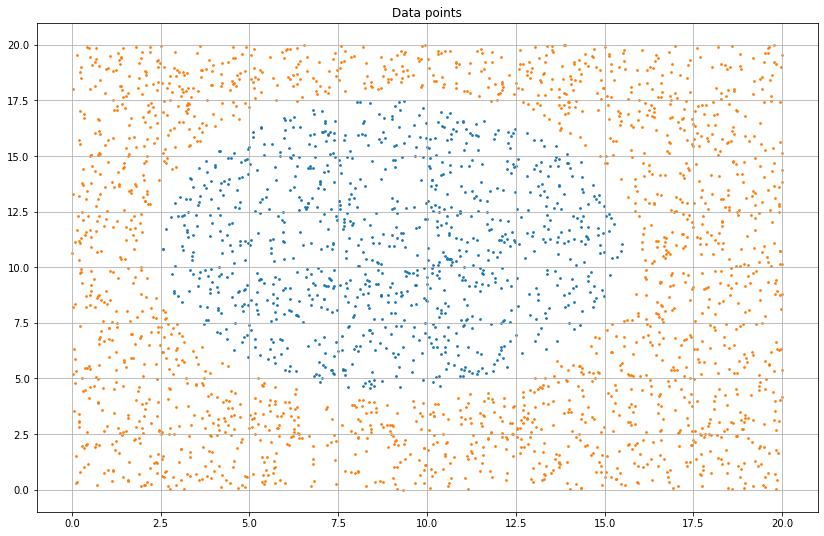

In [8]:
X,Y = create_data(radius_1,radius_2)
#training data
Xtrain = X[0:2000] 
Ytrain = Y[0:2000]
#testing data
Xtest = X[2000:]
Ytest = Y[2000:]

In [9]:
W1, b1, W2, b2 = gradient_descent(Xtrain, Ytrain,W1,b1,W2,b2, 200)
print(W1,b1,W2,b2)

<ipython-input-6-0e48e352ec3d>:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  Z1 = torch.matmul(W1,X.T) + b1 #weighted sum + bias(considering bias at each node) at the first hidden layer


Iteration:  0
Accuracy on training data:  0.656
Iteration:  5
Accuracy on training data:  0.743
Iteration:  10
Accuracy on training data:  0.754
Iteration:  15
Accuracy on training data:  0.764
Iteration:  20
Accuracy on training data:  0.764
Iteration:  25
Accuracy on training data:  0.7625
Iteration:  30
Accuracy on training data:  0.7675
Iteration:  35
Accuracy on training data:  0.77
Iteration:  40
Accuracy on training data:  0.769
Iteration:  45
Accuracy on training data:  0.771
Iteration:  50
Accuracy on training data:  0.7725
Iteration:  55
Accuracy on training data:  0.7835
Iteration:  60
Accuracy on training data:  0.7865
Iteration:  65
Accuracy on training data:  0.8005
Iteration:  70
Accuracy on training data:  0.896
Iteration:  75
Accuracy on training data:  0.9075
Iteration:  80
Accuracy on training data:  0.9175
Iteration:  85
Accuracy on training data:  0.925
Iteration:  90
Accuracy on training data:  0.93
Iteration:  95
Accuracy on training data:  0.9375
Iteration:  100

In [10]:
# calculating accuracy for testing data
def accuracy(X,W1,b1,W2,b2,Y) :
    count = 0 
    for i in range(X.size(0)) :
        Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, X[i])
        if Y[i] == arg_max(A2) :
            count = count + 1
    print("Accuracy : ",count/X.size(0))

In [11]:
accuracy(Xtest,W1,b1,W2,b2,Ytest)#accuarcy on testing data

Accuracy :  0.9294117647058824


In [12]:
# predicting the output from the model trained
my_tensor = torch.tensor([5.0,5.0,1])
print(my_tensor)
Z1, A1, Z2, A2 = forward(W1,b1,W2,b2,my_tensor)
print("predicted label:",arg_max(A2))

tensor([5., 5., 1.])
predicted label: -1
